In [ ]:
!pip3 install transformers
!pip3 install scikit-multilearn
!pip3 install iterative-stratification

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!apt-get install -y --no-install-recommends libcudnn8
!apt-mark hold libcudnn8

!nvcc --version
!echo "cudnn version:"
!cat /usr/local/cuda/include/cudnn_version.h | grep CUDNN_MAJOR -A 2


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-525
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8 libcudnn8-dev
2 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
E: Held packages were changed and -y was used without --allow-change-held-packages.
libcudnn8 was already set on hold.
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
cudnn version:
cat: /usr/local/cuda/include/cudnn_version.h: No such file or directory


In [ ]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'



In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the dataset
df = pd.read_csv("./data_balanced.csv")
df = df.drop(columns=['None', 'powerlabel'])
df.dropna(inplace=True)

# Convert labels to tensor
labels = df.iloc[:, 1:].values

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained('publichealthsurveillance/PHS-BERT')

# Tokenize input sentences and create attention masks
input_ids = []
attention_masks = []

for sentence in df['Content']:
    encoded_dict = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=387, padding='max_length', truncation=True, return_attention_mask=True, return_tensors='tf')
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert input_ids and attention_masks to tensors
input_ids = tf.concat(input_ids, axis=0)
attention_masks = tf.concat(attention_masks, axis=0)

# Prepare data for train-test split
X = np.hstack([input_ids.numpy(), attention_masks.numpy()])
y = labels

# Split the data into training and testing sets
train_X, test_X, train_y, test_y, train_index, test_index = train_test_split(X, y, df.index, test_size=0.2, random_state=42)

train_input_ids, train_attention_masks = train_X[:, :387], train_X[:, 387:]
test_input_ids, test_attention_masks = test_X[:, :387], test_X[:, 387:]
train_labels, test_labels = train_y, test_y

# Define the path to save the model
model_path = "./trained_model"

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

# Define model checkpoint callback
model_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True)

# Check if a saved model exists and load it, if it does
# Check if a saved model exists and load it, if it does
if os.path.exists(model_path):
    model = TFAutoModelForSequenceClassification.from_pretrained(model_path)
else:
    # Initialize the model
    model = TFAutoModelForSequenceClassification.from_pretrained('publichealthsurveillance/PHS-BERT', num_labels=labels.shape[1], from_pt=True)

    # Compile the model for training
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metric = tf.keras.metrics.BinaryAccuracy('accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    # Train the model
    history = model.fit(
        [train_input_ids, train_attention_masks],
        train_labels,
        epochs=1,
        batch_size=16,
        validation_data=(
            [test_input_ids, test_attention_masks],
            test_labels
        ),
        callbacks=[early_stopping, model_checkpoint]
    )


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


1993/1993 [==============================] - ETA: 0s - loss: 0.1894 - accuracy: 0.9284

1993/1993 [==============================] - 1209s 560ms/step - loss: 0.1894 - accuracy: 0.9284 - val_loss: 0.0939 - val_accuracy: 0.9707


In [ ]:
import tensorflow as tf
from transformers import TFBertForSequenceClassification

model.save_pretrained("./trained_model")
# Check if a saved model exists and load it
model_path = "./trained_model"

if os.path.exists(model_path):
    model = TFBertForSequenceClassification.from_pretrained(model_path)
else:
    print("Model not found. Please train the model and save it first.")

# Compile the loaded model
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metric = tf.keras.metrics.BinaryAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Convert test_input_ids and test_attention_masks to tensors
test_input_ids = tf.convert_to_tensor(test_input_ids)
test_attention_masks = tf.convert_to_tensor(test_attention_masks)

# Evaluate the model on the test data
evaluation_results = model.evaluate([test_input_ids, test_attention_masks], test_labels, batch_size=16)
print("Test loss: ", evaluation_results[0])
print("Test accuracy: ", evaluation_results[1])

Some layers from the model checkpoint at ./trained_model were not used when initializing TFBertForSequenceClassification: ['dropout_73']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./trained_model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


499/499 [==============================] - 91s 171ms/step - loss: 0.0939 - accuracy: 0.9707
Test loss:  0.0938863605260849
Test accuracy:  0.970672070980072


In [ ]:
# Evaluate the model on the test set
predictions = model.predict([test_input_ids, test_attention_masks])
logits = predictions.logits  # Access the logits from the output object
threshold = 0.5
predicted_labels = (np.array(logits, dtype=float) >= threshold).astype(int)
true_labels = test_labels


250/250 [==============================] - 81s 302ms/step


In [ ]:
from sklearn.metrics import classification_report
# Calculate metrics (precision, recall, F1 score)
label_names = ['symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5', 'symptom_6', 'symptom_7']
report = classification_report(true_labels, predicted_labels, output_dict=True, zero_division=0, target_names=label_names)

# Convert the report dictionary to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Display the classification report as a table
print("Classification report:")
print(report_df)

Classification report:
              precision    recall  f1-score  support
symptom_1      0.990394  0.977057  0.983681   2005.0
symptom_2      0.985138  0.977357  0.981232   1899.0
symptom_3      0.982117  0.929127  0.954887   2187.0
symptom_4      0.960621  0.805268  0.876111   2999.0
symptom_5      0.984767  0.867403  0.922367   2534.0
symptom_6      0.995485  0.947877  0.971098   1861.0
symptom_7      0.986700  0.942145  0.963908   2126.0
micro avg      0.982595  0.911345  0.945630  15611.0
macro avg      0.983603  0.920891  0.950469  15611.0
weighted avg   0.982066  0.911345  0.944539  15611.0
samples avg    0.528464  0.524386  0.524645  15611.0


In [ ]:
from sklearn.metrics import precision_recall_fscore_support, hamming_loss, jaccard_score

# Micro-averaged precision, recall, and F1 score
micro_precision, micro_recall, micro_f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='micro')
print("Micro-averaged Precision:", micro_precision)
print("Micro-averaged Recall:", micro_recall)
print("Micro-averaged F1 score:", micro_f1)

# Macro-averaged precision, recall, and F1 score
macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='macro')
print("Macro-averaged Precision:", macro_precision)
print("Macro-averaged Recall:", macro_recall)
print("Macro-averaged F1 score:", macro_f1)

# Hamming Loss
hamming = hamming_loss(true_labels, predicted_labels)
print("Hamming Loss:", hamming)

# Jaccard Score
jaccard = jaccard_score(true_labels, predicted_labels, average='samples')
print("Jaccard Score:", jaccard)


Micro-averaged Precision: 0.9825954831134747
Micro-averaged Recall: 0.911344564729998
Micro-averaged F1 score: 0.9456297773346626
Macro-averaged Precision: 0.9836030987900867
Macro-averaged Recall: 0.9208906590716746
Macro-averaged F1 score: 0.9504690473788363
Hamming Loss: 0.02932793144864923
Jaccard Score: 0.5208453590998452


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


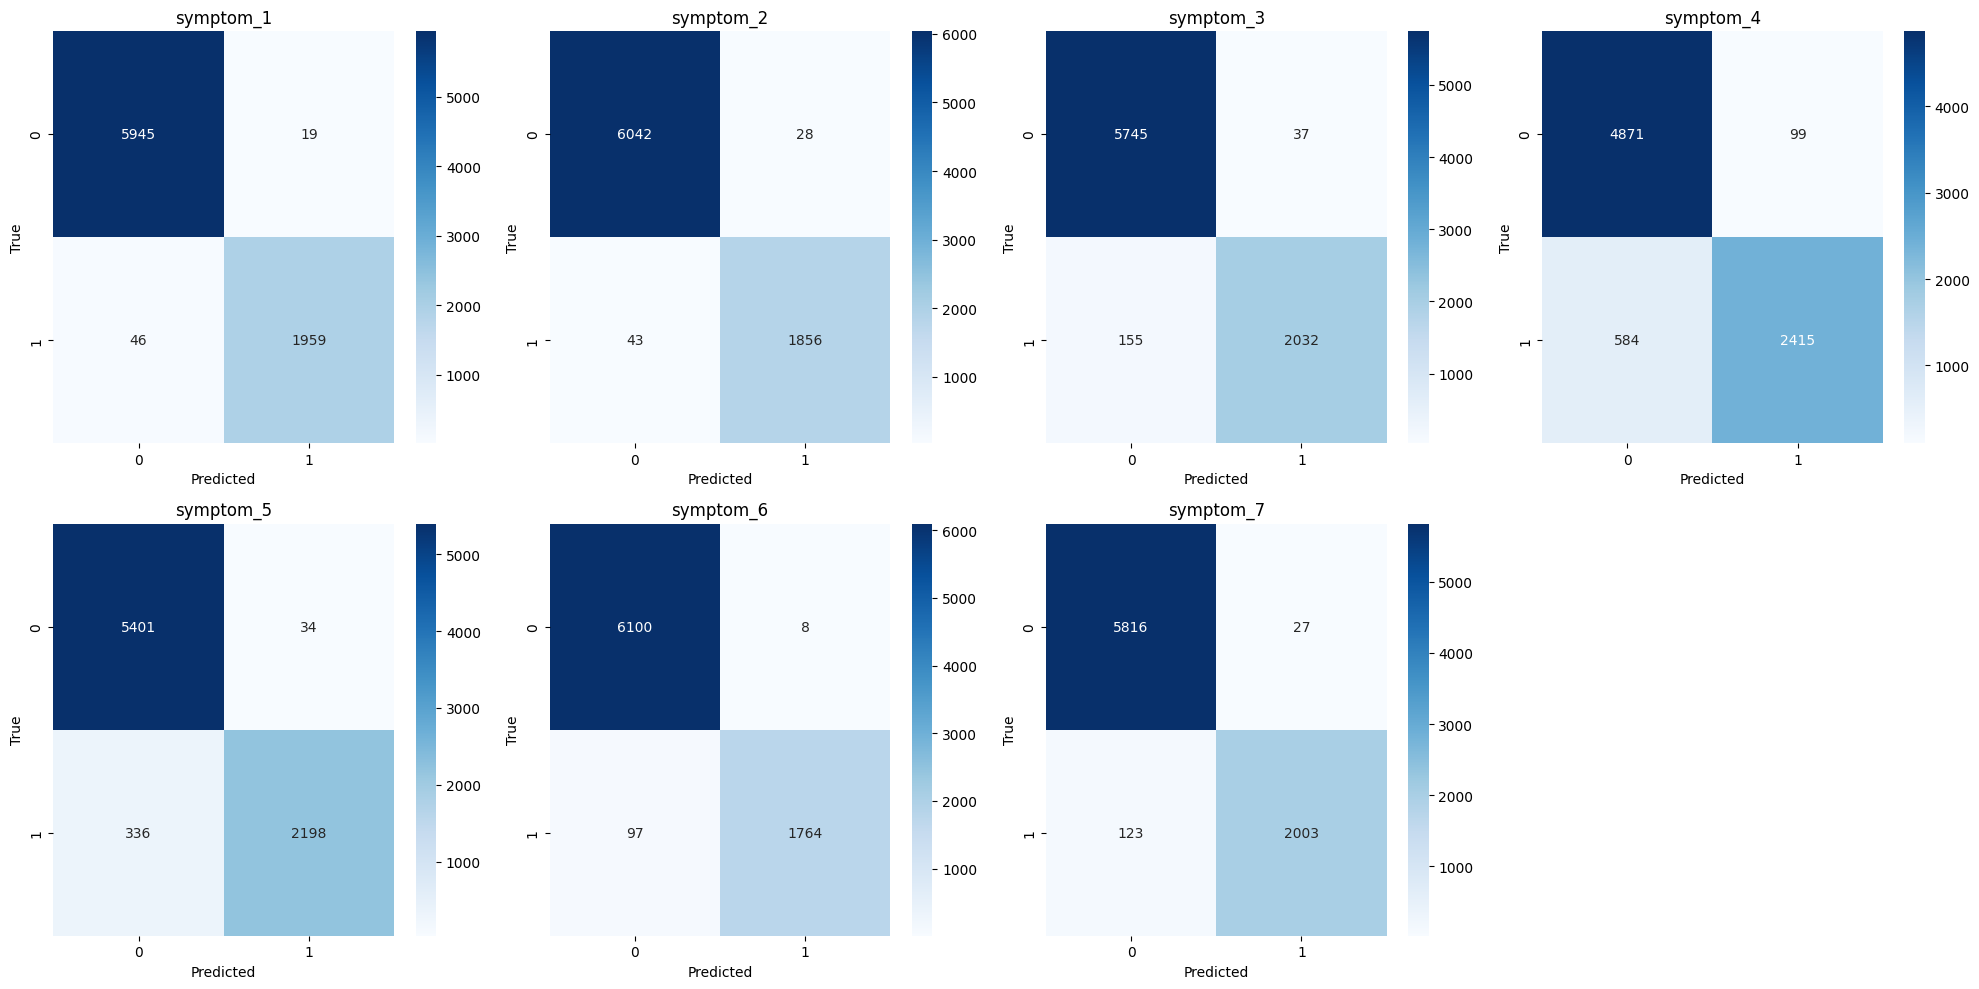

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
import matplotlib.pyplot as plt


# Calculate the confusion matrix
# Since this is a multi-label classification problem, we'll use multilabel_confusion_matrix
cm = multilabel_confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix
# label_names = ['symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5', 'symptom_6', 'symptom_7']

# Create a grid for subplots
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.delaxes(axes[1, 3])  # remove the last subplot (as we have only 7 labels)

for i, (label_name, ax) in enumerate(zip(label_names, axes.flat)):
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'{label_name}')

plt.tight_layout()
plt.show()

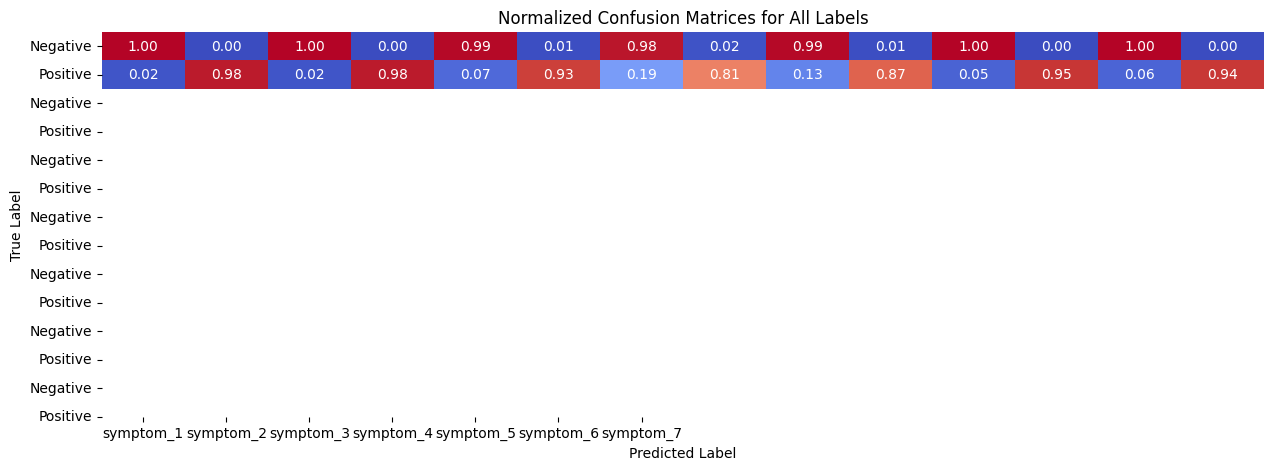

In [ ]:
# Create an empty list to store the normalized confusion matrices for each label
confusion_matrices = []

# Calculate the confusion matrices for each label and normalize them
for i in range(7):
    cm = confusion_matrix(true_labels[:, i], predicted_labels[:, i])
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    confusion_matrices.append(cm_normalized)

# Combine the normalized confusion matrices into a single array
combined_cm = np.concatenate(confusion_matrices, axis=1)

# Plot the heatmap
plt.figure(figsize=(15, 5))
sns.heatmap(combined_cm, annot=True, cmap="coolwarm", fmt=".2f", cbar=False, xticklabels=label_names, yticklabels=["Negative", "Positive"] * 7)

plt.title("Normalized Confusion Matrices for All Labels")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


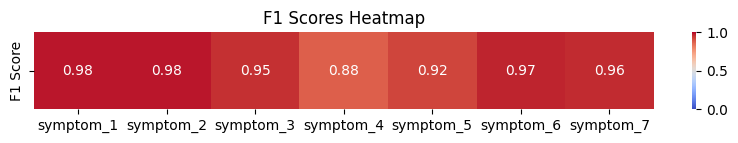

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate metrics (precision, recall, F1 score)
label_names = ['symptom_1', 'symptom_2', 'symptom_3', 'symptom_4', 'symptom_5', 'symptom_6', 'symptom_7']
report = classification_report(true_labels, predicted_labels, output_dict=True, zero_division=0, target_names=label_names)

# Extract F1 scores for each label
f1_scores = {label: report[label]['f1-score'] for label in label_names}

# Create a heatmap of F1 scores
f1_scores_matrix = np.array(list(f1_scores.values())).reshape(1, -1)
plt.figure(figsize=(10, 1))
sns.heatmap(f1_scores_matrix, annot=True, fmt='.2f', xticklabels=label_names, yticklabels=['F1 Score'], cmap='coolwarm', vmin=0, vmax=1)
plt.title('F1 Scores Heatmap')
plt.show()


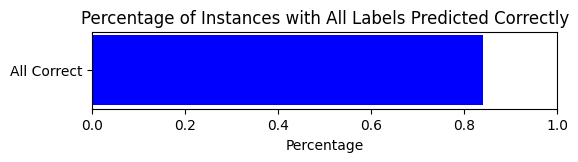

Exact Match Ratio: 0.84


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def all_correct_percentage(y_true, y_pred):
    correct = np.all(y_true == y_pred, axis=1)
    percentage = np.sum(correct) / len(correct)
    return percentage

# Calculate the percentage of instances with all labels predicted correctly
all_correct_pct = all_correct_percentage(true_labels, predicted_labels)

# Visualize the percentage
fig, ax = plt.subplots(figsize=(6, 1))
ax.barh(['All Correct'], [all_correct_pct], color='blue')
ax.set_xlim(0, 1)
ax.set_xlabel('Percentage')
ax.set_title('Percentage of Instances with All Labels Predicted Correctly')
plt.show()

def exact_match_ratio(true_labels, predicted_labels):
    assert true_labels.shape == predicted_labels.shape
    return np.all(true_labels == predicted_labels, axis=1).mean()

exact_match = exact_match_ratio(true_labels, predicted_labels)
print(f"Exact Match Ratio: {exact_match:.2f}")


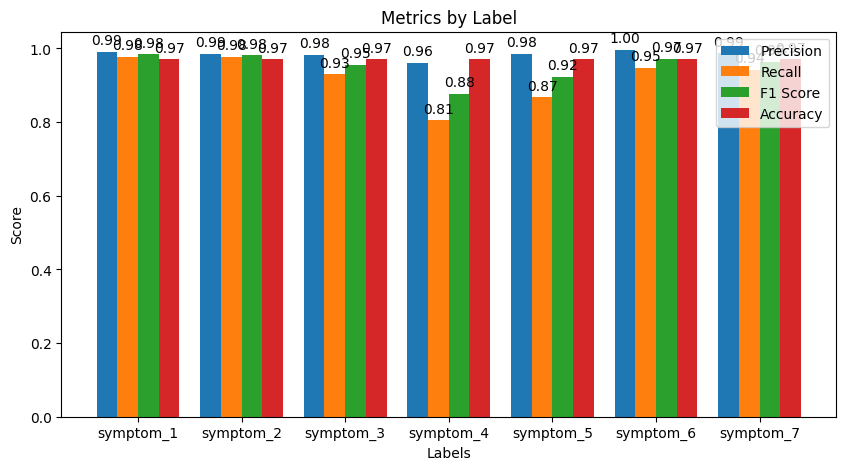

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract precision, recall, and F1 score from the classification report
precision = [report[label]['precision'] for label in label_names]
recall = [report[label]['recall'] for label in label_names]
f1_score = [report[label]['f1-score'] for label in label_names]

# Visualize the metrics together
fig, ax = plt.subplots(figsize=(10, 5))
labels = np.arange(len(label_names))
width = 0.2

rects1 = ax.bar(labels - 1.5 * width, precision, width, label='Precision')
rects2 = ax.bar(labels - 0.5 * width, recall, width, label='Recall')
rects3 = ax.bar(labels + 0.5 * width, f1_score, width, label='F1 Score')
rects4 = ax.bar(labels + 1.5 * width, [evaluation_results[1]] * len(labels), width, label='Accuracy')

ax.set_xlabel('Labels')
ax.set_xticks(labels)
ax.set_xticklabels(label_names)
ax.set_ylabel('Score')
ax.set_title('Metrics by Label')
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords='offset points',
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)

plt.show()

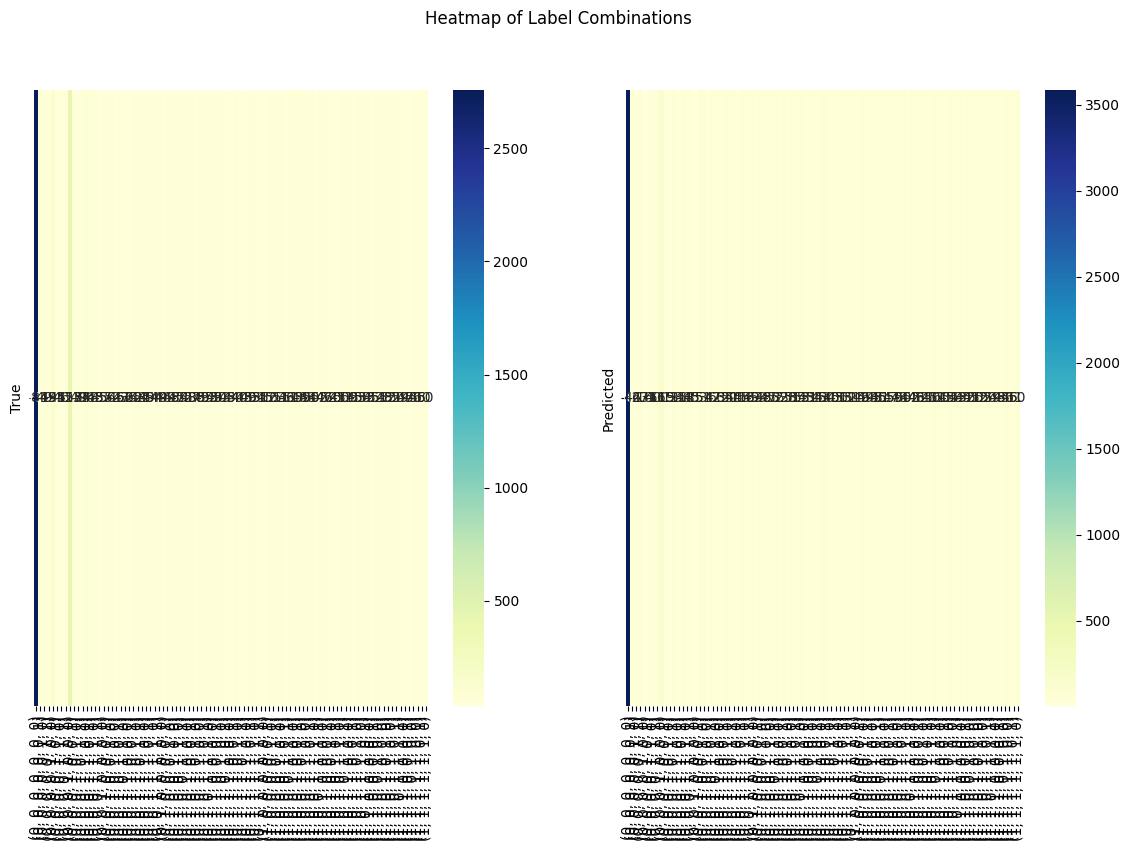

In [ ]:
import seaborn as sns
from collections import Counter

def label_combination_counts(labels):
    label_counts = Counter()
    for row in labels:
        label_counts[tuple(row)] += 1
    return label_counts

true_label_counts = label_combination_counts(true_labels)
predicted_label_counts = label_combination_counts(predicted_labels)

label_combinations = sorted(set(list(true_label_counts.keys()) + list(predicted_label_counts.keys())))
true_label_freq = [true_label_counts[combination] for combination in label_combinations]
predicted_label_freq = [predicted_label_counts[combination] for combination in label_combinations]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 8))
fig.suptitle('Heatmap of Label Combinations')

sns.heatmap([true_label_freq], xticklabels=label_combinations, yticklabels=["True"], annot=True, fmt="d", cmap="YlGnBu", ax=ax1)
sns.heatmap([predicted_label_freq], xticklabels=label_combinations, yticklabels=["Predicted"], annot=True, fmt="d", cmap="YlGnBu", ax=ax2)

plt.show()


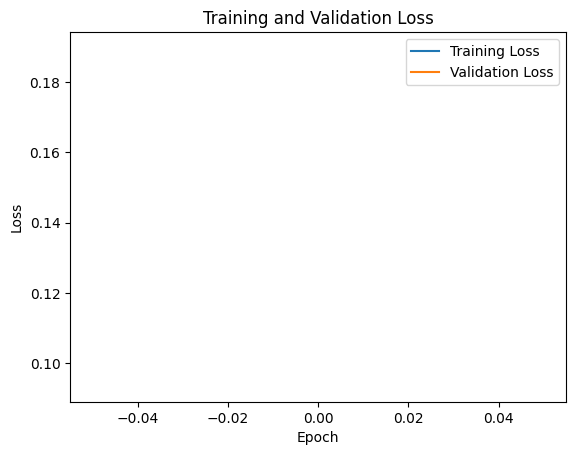

In [ ]:
# Plot training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

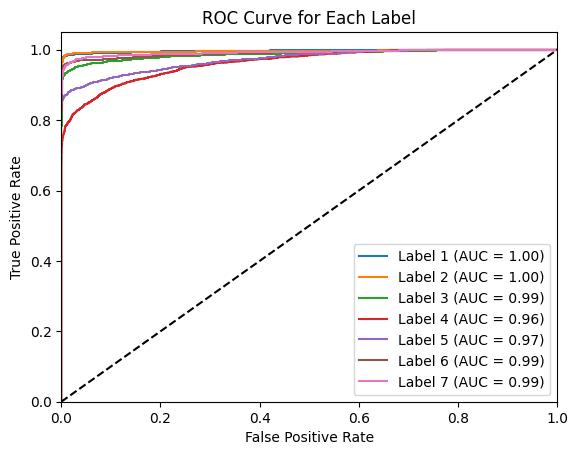

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Calculate ROC curve and AUC for each label

n_classes = train_labels.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

# Rest of the code remains the same


for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], logits[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Label {i + 1} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Label')
plt.legend(loc="lower right")
plt.show()

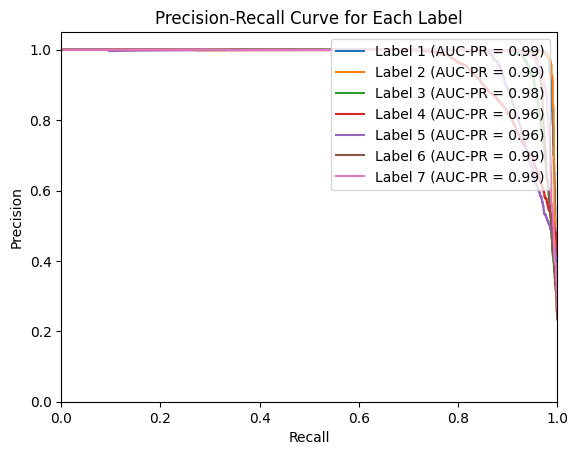

In [ ]:
# Calculate Precision-Recall curve and AUC-PR for each label
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(true_labels[:, i], logits[:, i])
    average_precision[i] = average_precision_score(true_labels[:, i], logits[:, i])

# Plot Precision-Recall curve
plt.figure()
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f'Label {i + 1} (AUC-PR = {average_precision[i]:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Label')
plt.legend(loc="upper right")
plt.show()

In [ ]:
from transformers import TFBertModel
import tensorflow as tf
# Get the attention weights from BERT
def get_attention_weights(input_ids, attention_masks):
    bert = TFBertModel.from_pretrained('bert-base-uncased', output_attentions=True)
    outputs = bert(input_ids, attention_mask=attention_masks)
    attentions = outputs.attentions
    return attentions

# Analyze the attention weights for a specific sample
sample_index = 0  # Change this to analyze different samples
input_id_sample = tf.reshape(test_input_ids[sample_index], (1, -1))
attention_mask_sample = tf.reshape(test_attention_masks[sample_index], (1, -1))

# Convert tensors to the appropriate format
input_id_sample = tf.convert_to_tensor(input_id_sample)
attention_mask_sample = tf.convert_to_tensor(attention_mask_sample)

attentions = get_attention_weights(input_id_sample, attention_mask_sample)

# Get the words from the input_ids
tokens = tokenizer.convert_ids_to_tokens(input_id_sample[0])

# Print the attention weights for the sample
for i, attention in enumerate(attentions):
    print(f"Layer {i + 1}")
    print(tokens)
    print(attention[0][0].numpy())
    print("\n")


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Layer 1
['[CLS]', 'shot', ',', 'like', 'really', 'losing', 'anything', ',', 'already', 'annoying', 'without', 'anything', 'lo', '##l', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '

In [ ]:
'''qualitative example'''
# Define indices of examples to examine
example_indices = [0, 1, 2, 3, 4, 5, 6]

# Convert the predicted probabilities to binary labels
test_predictions = model.predict([test_input_ids, test_attention_masks])
test_binary_predictions = (np.array(test_predictions.logits, dtype=float) >= 0.5).astype(int)

# Define label names
label_names = ['happiness', 'love', 'enthusiasm', 'fun', 'surprise', 'neutral', 'sadness']

# Choose some examples to examine in more detail
for i in example_indices:
    # Get the input text and true label for the example
    input_text = df['Content'].iloc[test_index[i]]
    true_label = test_labels[i]

    # Get the predicted label for the example
    predicted_label = test_binary_predictions[i]

    # Map the predicted label indices to their names
    predicted_label_names = [label_names[j] for j, label in enumerate(predicted_label) if label == 1]

    # Print the input text, true label, and predicted label
    print("Input text:", input_text)
    print("True label:", true_label)
    print("Predicted label:", predicted_label)

   


250/250 [==============================] - 75s 302ms/step
Input text: shot, like really losing anything, already annoying without anything lol
True label: [0 0 0 0 0 0 0]
Predicted label: [0 0 0 0 0 0 0]
Input text: live sort overthinking thing lot correctly now, spring break extended deuce week maybe even longer cannot handle isolation house, cannot blend in hang friend stupid sleep together virus barely even leave house, around parent really crippling, always make fun weight insult time point lock room never leave unless to, alone long really hard handle, starting overthink lot things. boyfriend want anymore, find someone good, many people could got reason chose really conflicted, really scared friend going get tired dealing me, stress thing time like driving insane cannot even sleep nights, sleep schedule fucked want hug mortal right straight off, tell going okay, really weak sometimes wish reassurance make this, even little bit, even much
True label: [1 1 1 1 1 0 0]
Predicted label

In [ ]:
# Error analysis
predictions = model.predict([test_input_ids, test_attention_masks])
logits = predictions.logits
threshold = 0.5
predicted_labels = (np.array(logits, dtype=float) >= threshold).astype(int)
true_labels = test_labels



250/250 [==============================] - 75s 302ms/step


In [ ]:
errors = []
for i, (pred, true) in enumerate(zip(predicted_labels, true_labels)):
    if not np.array_equal(pred, true):
        errors.append(i)

print(f"Total errors: {len(errors)}")



# Inspect a specific error
for i in range(1000):
  error_index = errors[i]  # Change this to analyze different errors
  error_df_index = test_index[error_index]  # Get the index in the original dataframe
  print(f"Error {error_index}")
  print("Content: ", df.iloc[error_df_index]['Content'])  # Print the content of the misclassified sample
  print("True labels: ", true_labels[error_index])
  print("Predicted labels: ", predicted_labels[error_index])
  error_content = df.iloc[error_df_index]['Content']
  print(f"Content: {error_content}")


Streaming output truncated to the last 5000 lines.
Error 7
Content:  Mel could right, I never know never say anything
True labels:  [0 0 0 1 0 1 0]
Predicted labels:  [0 0 0 0 0 0 0]
Content: Mel could right, I never know never say anything
Error 8
Content:  I Have dealing low point since like feb year I like hah! It cannot get worse last year! I fine!! But day I get lower lower think lowest ever
True labels:  [0 0 1 0 0 0 0]
Predicted labels:  [0 0 0 1 0 0 0]
Content: I Have dealing low point since like feb year I like hah! It cannot get worse last year! I fine!! But day I get lower lower think lowest ever
Error 9
Content:  Not saying try cry feel like could , good card play
True labels:  [0 0 0 0 1 0 1]
Predicted labels:  [0 0 0 0 0 0 0]
Content: Not saying try cry feel like could , good card play
Error 14
Content:  Nothing ruin everything waste parent money barren time blame everyone done trouble reason champion bad mood feeling like shit bringing mood
True labels:  [0 0 0 1 1 1 0]


In [ ]:
class TFBertModelWithAttention(TFBertModel):
    def call(self, inputs, **kwargs):
        outputs = self.bert(inputs, **kwargs)
        attention = outputs[-1]
        return outputs, attention
from transformers import TFBertForSequenceClassification, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('publichealthsurveillance/PHS-BERT')
model = TFBertForSequenceClassification.from_pretrained('publichealthsurveillance/PHS-BERT', from_pt=True)
bert_model = TFBertModelWithAttention.from_pretrained('publichealthsurveillance/PHS-BERT', from_pt=True)

# Get the attention weights for a single input (e.g., the first input in the test set)
input_id = tf.reshape(test_input_ids[0], (1, -1))
attention_mask = tf.reshape(test_attention_masks[0], (1, -1))

# Extract the attention weights
outputs, attention_weights = bert_model(input_id, attention_mask=attention_mask, output_attentions=True)
#_, _, attention_weights = bert_model(input_id, attention_mask=attention_mask, output_attentions=True)

attention_weights = np.array([aw.numpy() for aw in attention_weights])

# print(attention_weights.shape)

def select_top_heads(attention_weights, num_top_heads, layers_to_consider):
    num_layers, _, num_heads, _, _ = attention_weights.shape
    average_weights = np.mean(attention_weights, axis=(3, 4))

    # Only consider the layers specified in layers_to_consider
    weights_to_consider = average_weights[layers_to_consider, 0, :]
    top_heads_indices = np.argsort(weights_to_consider.ravel())[-num_top_heads:]
    top_heads = [(layers_to_consider[idx // num_heads], idx % num_heads) for idx in top_heads_indices]

    return top_heads

# Example usage:
num_top_heads = 5
layers_to_consider = [0, 11]  # Indices of layers 1 and 12

selected_heads = select_top_heads(attention_weights, num_top_heads, layers_to_consider)
print(selected_heads)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights

[(0, 3), (0, 2), (0, 1), (11, 14), (11, 15)]


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'bert.embeddings.position_ids', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

BERT Attention Visualization for Layer 1, Head 4:
Attention values (Layer 1, Head 4):
[[0.1948 0.0308 0.0216 0.0429 0.0498 0.0107 0.0438 0.0782 0.1035 0.0082
  0.0248 0.0721 0.3188]
 [0.1118 0.0728 0.1392 0.0698 0.0798 0.1199 0.0703 0.0257 0.0399 0.0671
  0.0896 0.0354 0.0786]
 [0.2189 0.0564 0.0802 0.0404 0.0551 0.0381 0.0511 0.0434 0.1003 0.0224
  0.0852 0.0571 0.1511]
 [0.0076 0.0132 0.0066 0.0999 0.024  0.0044 0.1302 0.0241 0.0104 0.0058
  0.007  0.0505 0.6164]
 [0.1674 0.0548 0.0409 0.0549 0.0302 0.1    0.0756 0.0202 0.0364 0.0334
  0.0601 0.0691 0.2571]
 [0.2113 0.0367 0.045  0.0288 0.1188 0.126  0.0276 0.0308 0.1262 0.0885
  0.0467 0.0331 0.0805]
 [0.0065 0.0093 0.0041 0.1121 0.0242 0.0031 0.1194 0.0216 0.0099 0.0039
  0.0058 0.0478 0.6322]
 [0.1111 0.0328 0.0764 0.0262 0.1781 0.1965 0.0466 0.0214 0.0323 0.1469
  0.0427 0.0266 0.0626]
 [0.0588 0.0194 0.0126 0.0494 0.0363 0.0273 0.0672 0.0449 0.0329 0.0071
  0.024  0.0372 0.583 ]
 [0.5431 0.0309 0.1343 0.0182 0.0198 0.03   0.0225

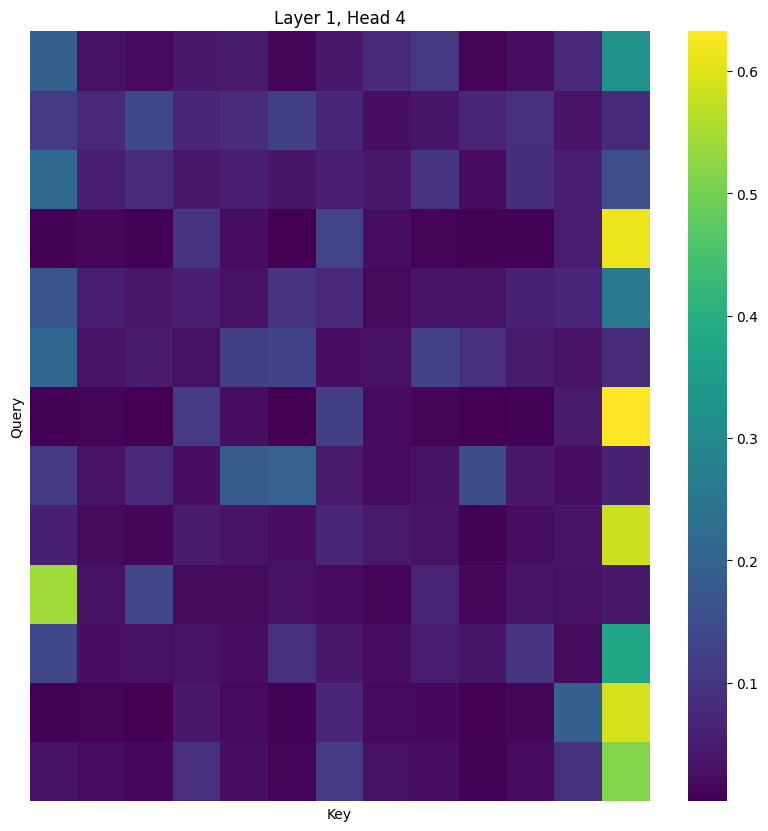

BERT Attention Visualization for Layer 1, Head 3:
Attention values (Layer 1, Head 3):
[[9.305e-01 3.000e-04 1.800e-03 0.000e+00 1.000e-04 2.000e-04 0.000e+00
  1.000e-04 0.000e+00 0.000e+00 4.000e-04 1.000e-04 6.650e-02]
 [1.481e-01 3.580e-01 1.159e-01 6.800e-03 3.550e-02 5.590e-02 6.500e-03
  3.940e-02 7.740e-02 2.230e-02 2.410e-02 2.540e-02 8.460e-02]
 [9.360e-02 2.310e-02 4.397e-01 2.180e-02 1.530e-02 2.760e-02 2.470e-02
  2.480e-02 5.030e-02 2.880e-02 1.710e-02 3.450e-02 1.987e-01]
 [7.060e-02 3.510e-02 1.540e-02 4.320e-02 6.000e-02 2.910e-02 4.810e-02
  3.870e-02 1.011e-01 3.470e-02 6.290e-02 2.990e-02 4.312e-01]
 [2.903e-01 2.190e-02 5.570e-02 1.440e-02 4.630e-02 2.670e-02 1.720e-02
  2.240e-02 2.880e-02 3.880e-02 4.950e-02 5.780e-02 3.300e-01]
 [2.841e-01 4.590e-02 5.590e-02 1.590e-02 3.770e-02 1.594e-01 1.380e-02
  3.540e-02 2.230e-02 6.770e-02 7.650e-02 5.460e-02 1.309e-01]
 [7.190e-02 4.070e-02 1.720e-02 6.070e-02 6.310e-02 2.150e-02 6.480e-02
  4.340e-02 7.840e-02 4.790e-02 

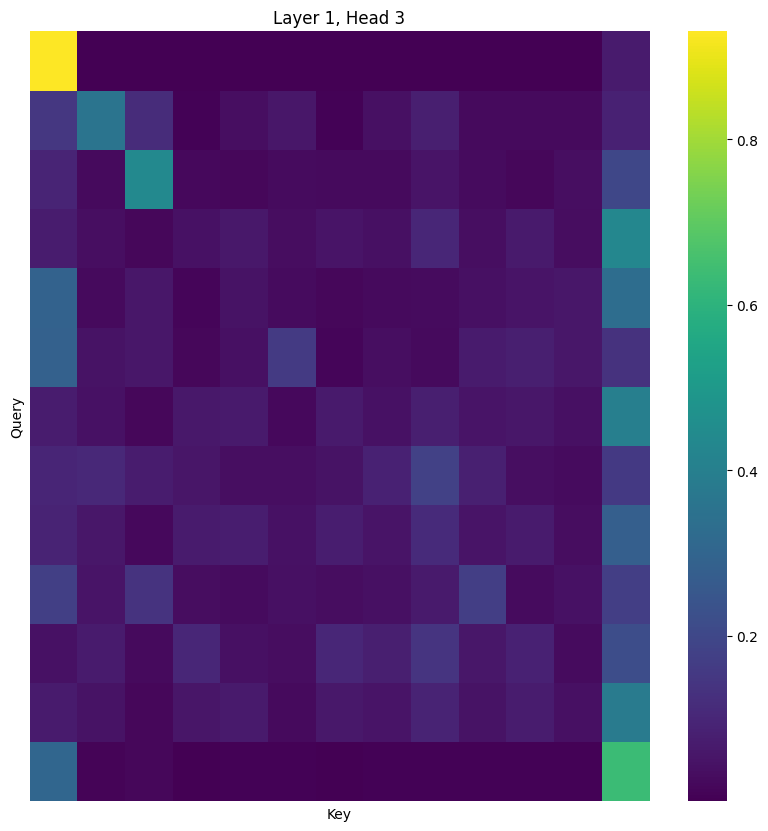

BERT Attention Visualization for Layer 1, Head 2:
Attention values (Layer 1, Head 2):
[[0.6733 0.0541 0.0296 0.     0.0428 0.0436 0.     0.022  0.0012 0.0127
  0.0073 0.     0.1133]
 [0.1501 0.0369 0.032  0.0361 0.0817 0.0666 0.042  0.0259 0.2059 0.0411
  0.0984 0.0461 0.1371]
 [0.3251 0.0382 0.0375 0.0507 0.0692 0.0965 0.0719 0.046  0.0781 0.0441
  0.0339 0.0624 0.0463]
 [0.0871 0.0808 0.0459 0.0143 0.1036 0.0321 0.017  0.0414 0.113  0.05
  0.0804 0.0159 0.3184]
 [0.1918 0.1022 0.086  0.0033 0.0435 0.0321 0.0034 0.0555 0.0181 0.1115
  0.0172 0.006  0.3295]
 [0.2316 0.0557 0.0987 0.0166 0.2124 0.0454 0.0174 0.0386 0.0771 0.0325
  0.051  0.019  0.104 ]
 [0.1084 0.063  0.0416 0.0146 0.1368 0.0314 0.0161 0.0432 0.1232 0.0451
  0.0652 0.0152 0.2963]
 [0.3231 0.0315 0.0484 0.0394 0.0954 0.073  0.0461 0.0239 0.0676 0.0864
  0.0364 0.0555 0.0732]
 [0.0658 0.0349 0.0485 0.0342 0.0847 0.0177 0.0361 0.0496 0.2525 0.0804
  0.0617 0.0477 0.186 ]
 [0.1216 0.0435 0.0292 0.0392 0.0426 0.0478 0.0543 0

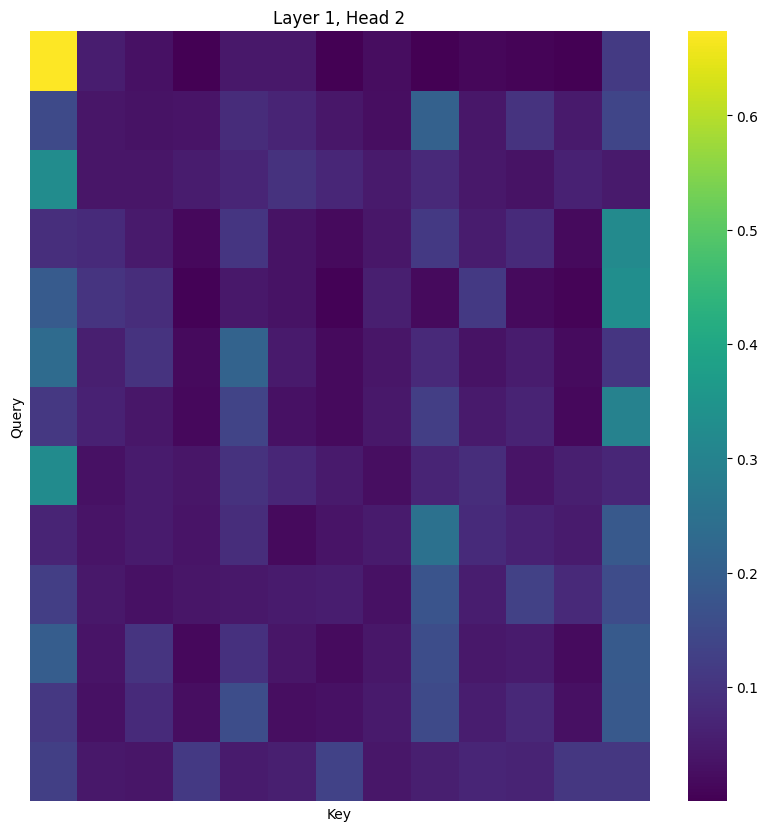

BERT Attention Visualization for Layer 12, Head 15:
Attention values (Layer 12, Head 15):
[[0.8927 0.008  0.0074 0.0063 0.0059 0.0022 0.005  0.0092 0.0059 0.0063
  0.006  0.0074 0.0377]
 [0.2794 0.0125 0.3851 0.0125 0.0091 0.0172 0.0108 0.1021 0.064  0.0245
  0.01   0.0211 0.0518]
 [0.7055 0.0107 0.0175 0.0059 0.0124 0.0132 0.0074 0.0765 0.0271 0.0451
  0.0172 0.0109 0.0505]
 [0.058  0.1676 0.1069 0.0427 0.1798 0.0637 0.0256 0.1663 0.0392 0.037
  0.0693 0.0175 0.0264]
 [0.1309 0.011  0.0778 0.0129 0.01   0.1842 0.0213 0.0971 0.1122 0.1689
  0.0515 0.0457 0.0767]
 [0.2936 0.031  0.1842 0.0073 0.0072 0.0091 0.0136 0.062  0.0382 0.1279
  0.0471 0.0513 0.1275]
 [0.1098 0.1076 0.0527 0.0464 0.1523 0.0503 0.0405 0.1563 0.0462 0.089
  0.0992 0.0237 0.026 ]
 [0.0458 0.0047 0.0112 0.0044 0.0056 0.0582 0.008  0.012  0.0491 0.6408
  0.0589 0.0404 0.0608]
 [0.0633 0.0181 0.0206 0.011  0.0119 0.0196 0.0217 0.015  0.012  0.6566
  0.053  0.0428 0.0543]
 [0.3343 0.0651 0.1987 0.0099 0.0635 0.0171 0.01

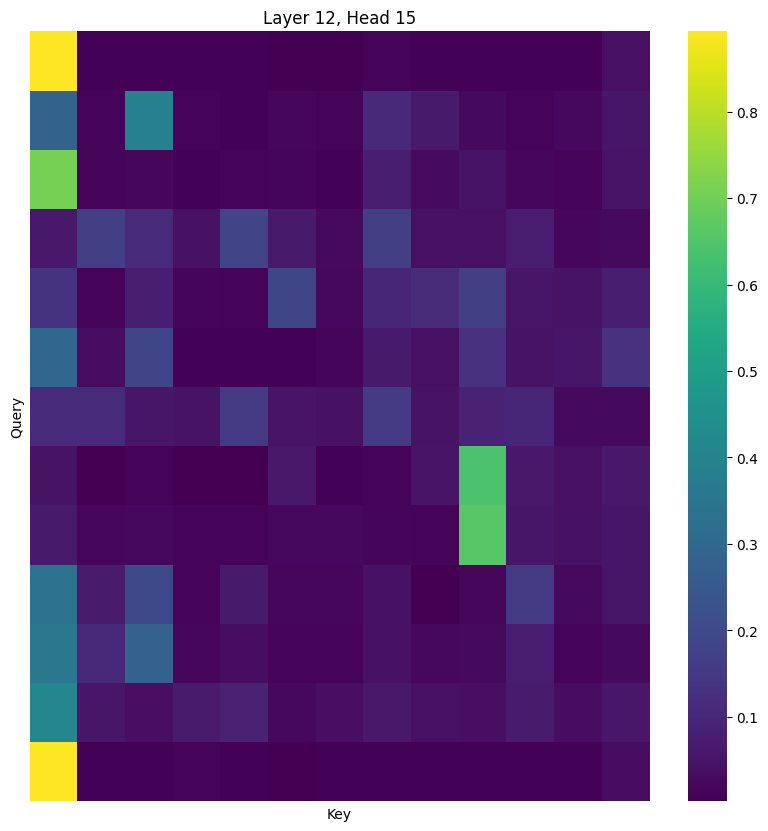

BERT Attention Visualization for Layer 12, Head 16:
Attention values (Layer 12, Head 16):
[[8.327e-01 3.600e-03 7.100e-03 3.700e-03 2.500e-03 1.160e-02 4.800e-03
  2.400e-03 1.800e-03 8.800e-03 3.900e-03 2.180e-02 9.520e-02]
 [7.265e-01 1.500e-03 6.000e-04 3.700e-03 1.000e-03 4.000e-04 4.300e-03
  4.000e-04 5.000e-04 1.500e-03 6.000e-04 3.120e-02 2.277e-01]
 [6.976e-01 3.200e-03 1.300e-03 5.100e-03 2.100e-03 4.000e-04 6.400e-03
  1.000e-03 6.000e-04 1.200e-03 3.300e-03 3.010e-02 2.478e-01]
 [6.358e-01 8.700e-03 1.270e-02 1.430e-02 4.700e-03 7.700e-03 1.920e-02
  5.300e-03 4.800e-03 5.400e-03 5.600e-03 7.350e-02 2.023e-01]
 [5.155e-01 2.010e-02 5.600e-03 2.440e-02 4.100e-03 2.200e-03 2.440e-02
  5.600e-03 3.600e-03 4.600e-03 8.200e-03 7.080e-02 3.109e-01]
 [7.062e-01 2.000e-03 2.000e-03 1.790e-02 3.100e-03 1.100e-03 2.520e-02
  9.000e-04 6.000e-04 2.500e-03 2.100e-03 2.850e-02 2.078e-01]
 [5.339e-01 1.690e-02 1.920e-02 2.580e-02 6.200e-03 1.230e-02 3.110e-02
  5.900e-03 6.000e-03 9.900e

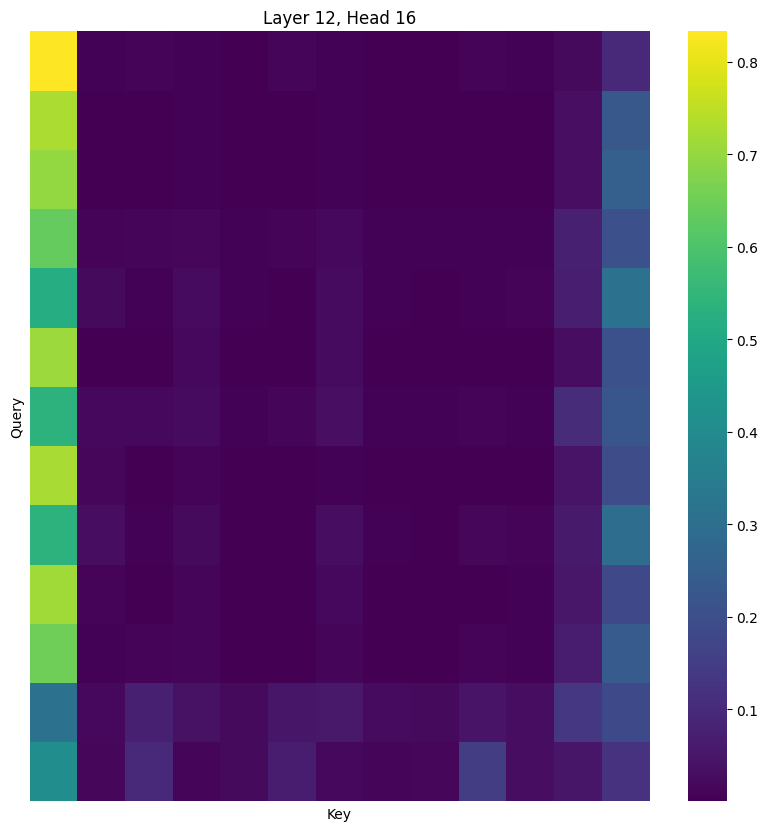

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, TFAutoModel

tokenizer = AutoTokenizer.from_pretrained('publichealthsurveillance/PHS-BERT')
bert_model = TFAutoModel.from_pretrained('publichealthsurveillance/PHS-BERT', from_pt=True)

# sample_sentence = "Can't sleep, always tired, hard to focus."
sample_sentence = "Lost appetite, feel guilty, thinking of ending it."

bert_tokens = tokenizer.encode_plus(sample_sentence, add_special_tokens=True, return_tensors="tf")
bert_outputs = bert_model(bert_tokens['input_ids'], attention_mask=bert_tokens['attention_mask'], output_attentions=True)
bert_attention = bert_outputs.attentions

def plot_attention(tokens, attention, layer, head):
    plt.figure(figsize=(10, 10))
    tokens = tokenizer.convert_ids_to_tokens(tokens.numpy()[0])
    attention_values = attention[layer][0, head].numpy()
    print(f"Attention values (Layer {layer + 1}, Head {head + 1}):")
    print(np.round(attention_values, decimals=4))
    ax = sns.heatmap(attention_values, xticklabels=False, yticklabels=False, cmap='viridis', annot=False)
    ax.xaxis.tick_top()
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.title(f"Layer {layer + 1}, Head {head + 1}")
    plt.show()

selected_heads = [(0, 3), (0, 2), (0, 1), (11, 14), (11, 15)]

for layer, head in selected_heads:
  print(f"BERT Attention Visualization for Layer {layer + 1}, Head {head + 1}:")
  plot_attention(bert_tokens['input_ids'], bert_attention, layer, head)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'bert.embeddings.position_ids', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

BERT Attention Visualization for Layer 1, Head 4:
Attention values (Layer 1, Head 4):
[[0.1801 0.0557 0.0228 0.0973 0.0296 0.0411 0.0347 0.0094 0.0368 0.0246
  0.0795 0.0128 0.0654 0.3103]
 [0.0605 0.0353 0.0499 0.033  0.0366 0.1197 0.0626 0.0551 0.1378 0.0476
  0.0306 0.076  0.0575 0.1978]
 [0.1655 0.0495 0.0131 0.0191 0.0071 0.0768 0.0432 0.0287 0.0682 0.0179
  0.0424 0.0164 0.0324 0.4197]
 [0.0921 0.0806 0.0757 0.0093 0.0208 0.0571 0.0388 0.0273 0.0542 0.0184
  0.0468 0.0569 0.0308 0.3914]
 [0.2493 0.0696 0.032  0.0126 0.089  0.02   0.0612 0.1    0.0156 0.1589
  0.0498 0.0856 0.0173 0.0391]
 [0.0068 0.0094 0.0284 0.0083 0.0066 0.1166 0.0092 0.0098 0.1059 0.005
  0.0085 0.0068 0.0446 0.634 ]
 [0.3614 0.0674 0.0358 0.0125 0.0252 0.0309 0.0558 0.0479 0.0218 0.0535
  0.0454 0.0364 0.0099 0.196 ]
 [0.1397 0.0298 0.0224 0.0072 0.176  0.0273 0.0778 0.1119 0.0191 0.1491
  0.0889 0.1028 0.0189 0.0292]
 [0.008  0.0081 0.0255 0.0068 0.0063 0.1263 0.0118 0.0099 0.0947 0.0051
  0.0089 0.0074 0.0

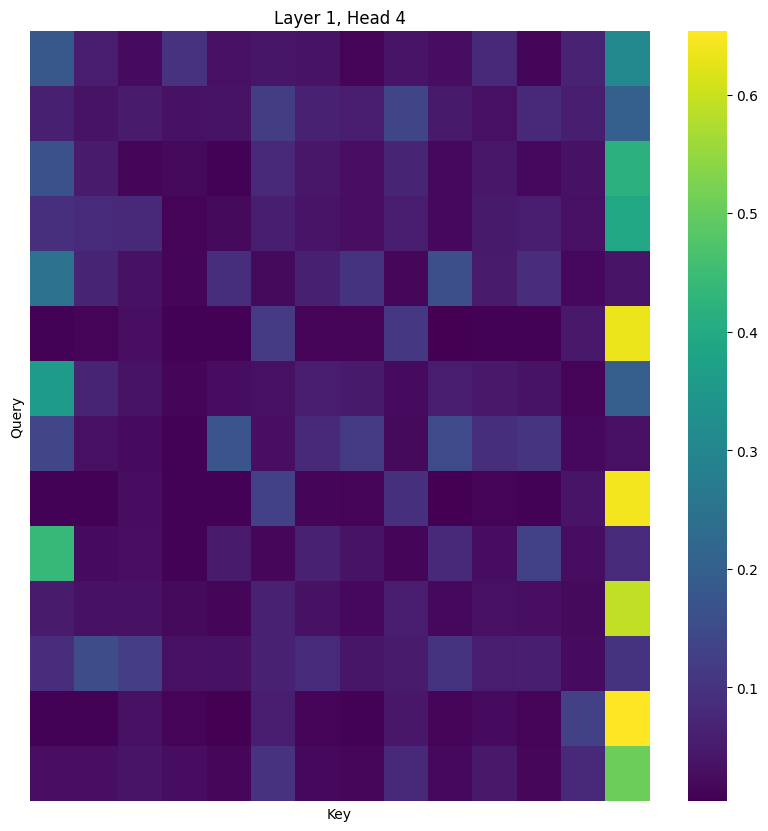

BERT Attention Visualization for Layer 1, Head 3:
Attention values (Layer 1, Head 3):
[[8.983e-01 4.000e-04 2.000e-04 1.000e-04 2.000e-04 0.000e+00 1.000e-04
  2.000e-04 0.000e+00 1.000e-04 0.000e+00 3.000e-04 0.000e+00 1.001e-01]
 [5.670e-02 1.320e-02 2.760e-02 2.470e-02 4.860e-02 7.630e-02 5.020e-02
  3.630e-02 6.160e-02 2.690e-02 6.250e-02 7.540e-02 4.120e-02 3.986e-01]
 [8.300e-02 1.780e-02 8.640e-02 3.520e-02 2.850e-02 2.160e-02 3.730e-02
  2.820e-02 1.940e-02 2.180e-02 5.210e-02 3.760e-02 2.940e-02 5.015e-01]
 [7.600e-02 4.730e-02 3.460e-02 1.415e-01 2.030e-02 4.720e-02 4.020e-02
  3.020e-02 4.210e-02 3.370e-02 1.900e-01 3.840e-02 2.560e-02 2.327e-01]
 [9.930e-02 2.250e-02 1.620e-02 1.440e-02 4.682e-01 1.380e-02 2.510e-02
  1.003e-01 1.270e-02 3.280e-02 1.440e-02 4.730e-02 4.170e-02 9.130e-02]
 [6.280e-02 3.250e-02 3.860e-02 6.590e-02 3.560e-02 5.650e-02 2.740e-02
  3.800e-02 4.250e-02 2.440e-02 1.236e-01 3.380e-02 3.300e-02 3.856e-01]
 [1.479e-01 1.880e-02 1.620e-02 3.300e-02 2.

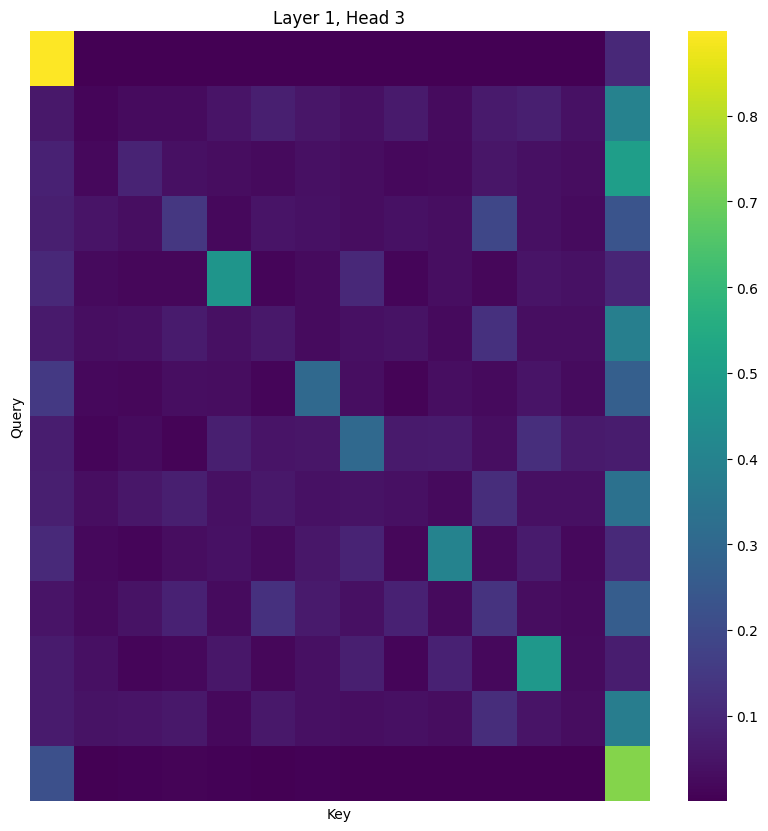

BERT Attention Visualization for Layer 1, Head 2:
Attention values (Layer 1, Head 2):
[[4.724e-01 5.470e-02 8.000e-03 2.910e-02 6.490e-02 0.000e+00 1.590e-01
  9.100e-03 0.000e+00 3.750e-02 2.000e-04 5.820e-02 0.000e+00 1.070e-01]
 [1.653e-01 2.980e-02 2.220e-02 1.551e-01 6.560e-02 1.920e-02 1.542e-01
  4.850e-02 1.130e-02 3.950e-02 9.930e-02 5.310e-02 1.520e-02 1.216e-01]
 [8.120e-02 6.980e-02 1.545e-01 2.510e-02 3.140e-02 1.590e-02 6.200e-02
  7.970e-02 1.820e-02 5.440e-02 4.730e-02 1.028e-01 1.940e-02 2.381e-01]
 [3.276e-01 8.890e-02 2.910e-02 3.630e-02 4.490e-02 8.300e-03 1.453e-01
  7.220e-02 8.700e-03 8.390e-02 2.340e-02 4.360e-02 6.700e-03 8.110e-02]
 [3.063e-01 6.470e-02 1.250e-02 1.732e-01 1.430e-02 5.900e-03 1.563e-01
  1.510e-02 6.000e-03 3.270e-02 1.950e-02 7.060e-02 8.800e-03 1.141e-01]
 [1.006e-01 8.630e-02 2.460e-02 6.240e-02 5.000e-02 1.080e-02 1.397e-01
  4.820e-02 9.900e-03 3.000e-02 1.071e-01 5.100e-02 1.000e-02 2.694e-01]
 [2.469e-01 3.010e-02 9.800e-03 4.850e-02 7.

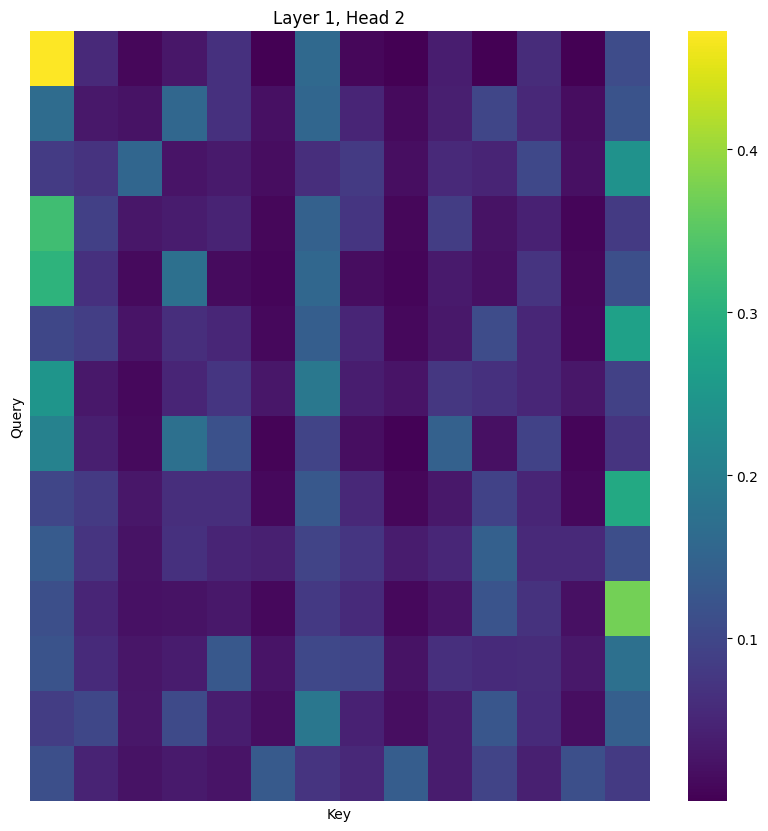

BERT Attention Visualization for Layer 12, Head 15:
Attention values (Layer 12, Head 15):
[[0.9046 0.0041 0.0101 0.0027 0.0033 0.0035 0.0024 0.0018 0.0034 0.0043
  0.0019 0.0029 0.0061 0.0489]
 [0.2    0.004  0.0544 0.0055 0.1511 0.0339 0.0357 0.0259 0.02   0.0114
  0.0057 0.2015 0.0875 0.1635]
 [0.8746 0.0101 0.0106 0.0047 0.0059 0.0065 0.0044 0.0071 0.0059 0.008
  0.0045 0.0053 0.007  0.0453]
 [0.1621 0.0062 0.0158 0.0051 0.4084 0.008  0.0109 0.055  0.0041 0.0204
  0.0038 0.2073 0.0248 0.0682]
 [0.6034 0.0217 0.0385 0.0118 0.0319 0.0171 0.0101 0.0127 0.0105 0.0381
  0.0026 0.0175 0.0418 0.1422]
 [0.1053 0.0752 0.0175 0.0957 0.1583 0.0283 0.0428 0.1447 0.0284 0.1364
  0.0634 0.0315 0.0274 0.0449]
 [0.1074 0.0296 0.0098 0.037  0.0785 0.0249 0.038  0.1275 0.0261 0.1236
  0.2953 0.0375 0.0251 0.0396]
 [0.6732 0.0121 0.0135 0.0142 0.016  0.0055 0.0221 0.0104 0.0057 0.0198
  0.0186 0.1051 0.0127 0.0712]
 [0.122  0.0635 0.0104 0.0438 0.0656 0.0203 0.0356 0.1512 0.0367 0.2357
  0.1192 0.043 

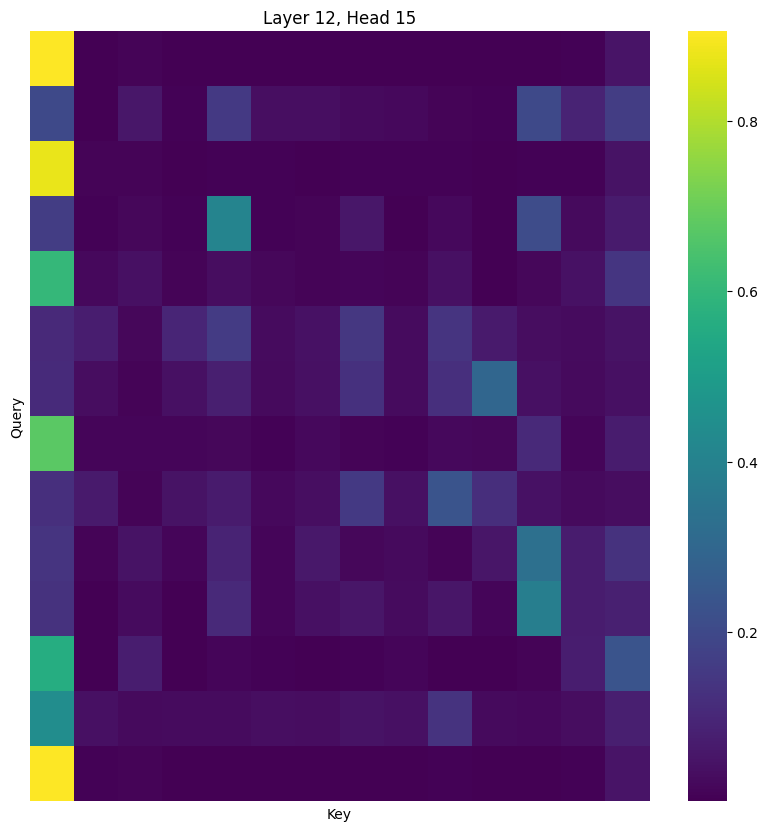

BERT Attention Visualization for Layer 12, Head 16:
Attention values (Layer 12, Head 16):
[[8.339e-01 2.700e-03 2.130e-02 1.800e-03 2.500e-03 2.500e-03 6.000e-04
  4.600e-03 2.900e-03 2.400e-03 1.000e-03 3.200e-03 1.620e-02 1.044e-01]
 [6.253e-01 1.570e-02 3.250e-02 7.200e-03 1.500e-02 3.700e-03 4.500e-03
  2.480e-02 6.100e-03 1.700e-03 9.800e-03 2.300e-03 2.380e-02 2.278e-01]
 [3.609e-01 2.620e-02 1.177e-01 1.950e-02 2.830e-02 2.150e-02 1.650e-02
  2.850e-02 2.230e-02 8.060e-02 8.200e-03 5.020e-02 7.090e-02 1.488e-01]
 [6.338e-01 7.300e-03 3.170e-02 6.300e-03 1.100e-02 3.800e-03 3.700e-03
  2.990e-02 4.600e-03 2.200e-03 4.100e-03 4.200e-03 2.400e-02 2.333e-01]
 [7.241e-01 1.860e-02 2.710e-02 6.600e-03 5.100e-03 3.500e-03 4.000e-03
  1.360e-02 6.700e-03 4.000e-04 1.320e-02 9.000e-04 1.240e-02 1.640e-01]
 [5.721e-01 7.100e-03 4.740e-02 8.500e-03 1.220e-02 1.640e-02 6.400e-03
  1.890e-02 1.880e-02 4.900e-03 8.300e-03 3.500e-03 7.050e-02 2.049e-01]
 [6.459e-01 3.400e-03 6.220e-02 3.000e-0

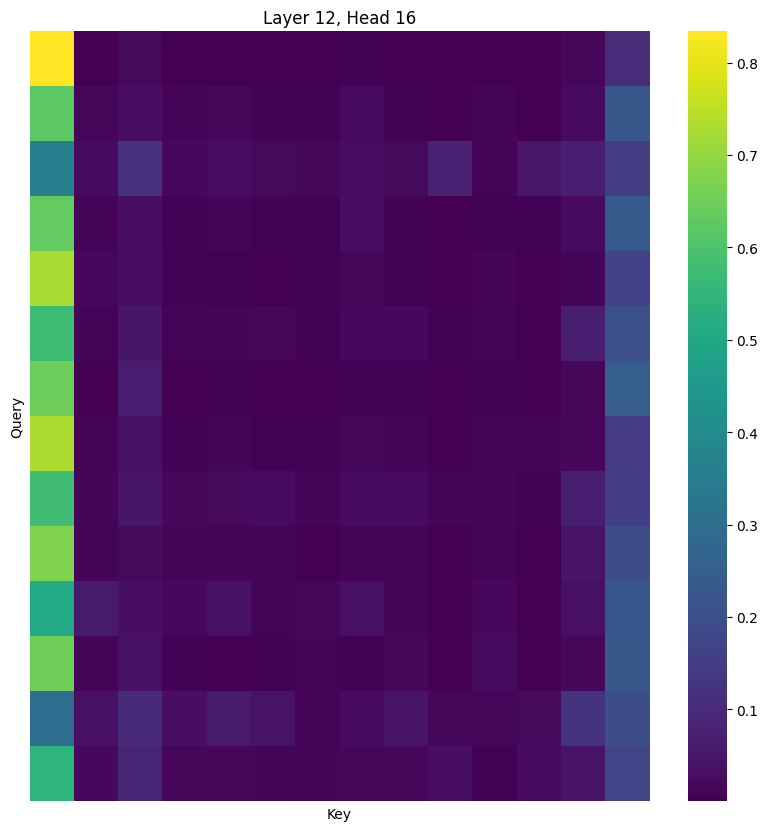

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, TFAutoModel

tokenizer = AutoTokenizer.from_pretrained('publichealthsurveillance/PHS-BERT')
bert_model = TFAutoModel.from_pretrained('publichealthsurveillance/PHS-BERT', from_pt=True)

sample_sentence = "Can't sleep, always tired, hard to focus."
# sample_sentence = "Lost appetite, feel guilty, thinking of ending it."

bert_tokens = tokenizer.encode_plus(sample_sentence, add_special_tokens=True, return_tensors="tf")
bert_outputs = bert_model(bert_tokens['input_ids'], attention_mask=bert_tokens['attention_mask'], output_attentions=True)
bert_attention = bert_outputs.attentions

def plot_attention(tokens, attention, layer, head):
    plt.figure(figsize=(10, 10))
    tokens = tokenizer.convert_ids_to_tokens(tokens.numpy()[0])
    attention_values = attention[layer][0, head].numpy()
    print(f"Attention values (Layer {layer + 1}, Head {head + 1}):")
    print(np.round(attention_values, decimals=4))
    ax = sns.heatmap(attention_values, xticklabels=False, yticklabels=False, cmap='viridis', annot=False)
    ax.xaxis.tick_top()
    plt.xlabel("Key")
    plt.ylabel("Query")
    plt.title(f"Layer {layer + 1}, Head {head + 1}")
    plt.show()

selected_heads = [(0, 3), (0, 2), (0, 1), (11, 14), (11, 15)]

for layer, head in selected_heads:
  print(f"BERT Attention Visualization for Layer {layer + 1}, Head {head + 1}:")
  plot_attention(bert_tokens['input_ids'], bert_attention, layer, head)